<a href="https://colab.research.google.com/github/MrCogito/Spectrogram-Generator/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import TensorFlow and other libraries



In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt 
import pathlib
import os
from google.colab import drive
import time
import librosa
import librosa.display




In [2]:
drive.mount('/content/gdrive') #Mount google driv

Mounted at /content/gdrive


In [3]:
tf.__version__

'2.7.0'

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))



Found GPU at: /device:GPU:0


# Load and prepare the dataset

float32
(12196, 256, 14)
1.0000001
-1.0
(12196, 256, 14, 1)


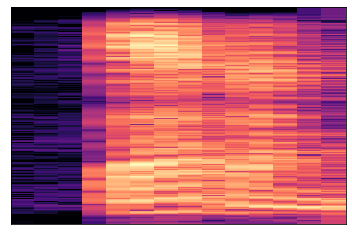

In [5]:
# Load data

data_tensor = np.load('/content/gdrive/MyDrive/Inzynierka/Data/en_spectrogram_tensor/Dataset_spectrogram_256_14.npy')
#print(data_tensor)
print(data_tensor.dtype)
print(data_tensor.shape)
librosa.display.specshow(data_tensor[3])
data_tensor = (data_tensor + 40) / 40
#print(data_tensor.shape)
print(np.max(data_tensor))
print(np.min(data_tensor))
data_tensor = data_tensor.reshape(12196, 256, 14, 1)
print(data_tensor.shape)
BUFFER_SIZE = 12196
BATCH_SIZE = 128

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(data_tensor).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



# Build the generator

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*7*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))

    model.add(layers.Reshape((8, 7, 128)))
    assert model.output_shape == (None, 8, 7, 128)  # ensure size is correct None is batch size
   
   
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    print(model.output_shape)
    assert model.output_shape == (None, 16, 14, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))
    
    model.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
    print(model.output_shape)
    assert model.output_shape == (None, 32, 28, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))

    model.add(layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"))
    print(model.output_shape)
    assert model.output_shape == (None, 64, 56, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))
    
    model.add(layers.Conv2D(1, kernel_size=5, padding="same", activation="sigmoid"))
    print(model.output_shape)
    model.add(layers.Reshape((256,14,1)))
    print(model.output_shape)
    return model





In [7]:
generator = make_generator_model()
generator.summary()

(None, 16, 14, 128)
(None, 32, 28, 256)
(None, 64, 56, 512)
(None, 64, 56, 1)
(None, 256, 14, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7168)              716800    
                                                                 
 batch_normalization (BatchN  (None, 7168)             28672     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7168)              0         
                                                                 
 reshape (Reshape)           (None, 8, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 14, 128)      262272    
 nspose)                                                         
                         

(1, 256, 14, 1)


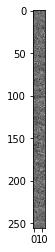

In [8]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
print(generated_image.shape)

# Build the discriminator


In [9]:
def make_discriminator_model():
  
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same',input_shape=[256, 14, 1]))
  model.add(layers.LeakyReLU(alpha=0.3))

  model.add(layers.Conv2D(128, (5,5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.3))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(256, (5,5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.3))
  model.add(layers.Dropout(0.3))



  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model



In [10]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)
discriminator.summary()

tf.Tensor([[0.01427418]], shape=(1, 1), dtype=float32)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 7, 64)        1088      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 7, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 4, 128)        204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 4, 128)        0         
                                                                 
 dropout (Dropout)           (None, 64, 4, 128)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 2, 256)        819456    
                                                                 

# Define the loss and optimizers


In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # from_logits=True return value in [-inf, inf]

In [12]:
#discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    total_loss = real_loss + fake_loss
    return total_loss, fake_loss, real_loss
    

In [13]:
#generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
#optimizers 
generator_optimizer = tf.keras.optimizers.Adam(0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0001)

# Save checkpoints


In [28]:
checkpoint_dir = '/content/gdrive/MyDrive/Inzynierka/Data/Results/v1/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Save and plot history

In [24]:
def plot_history(d1_hist, g_hist,epochs):
  # plot loss
	plt.subplot(2,1,1)
	plt.plot(d1_hist, label='disc loss')
	plt.legend()
	plt.subplot(2,1,2)
	plt.plot(g_hist, label='gen loss')
	plt.legend()
	#plt.show()
	# plot discriminator accuracy
	# save plot to file
	plt.savefig('/content/gdrive/MyDrive/Inzynierka/Data/Results/v1_DG' + str(epochs))
	plt.close()

In [25]:
def plot_history2(dfake_hist, dreal_hist,epochs):
  # plot loss
	plt.subplot(2,1,1)
	plt.plot(dfake_hist, label='dfake_hist')
	plt.legend()
	plt.subplot(2,1,2)
	plt.plot(dreal_hist, label='dreal_hist')
	plt.legend()
	#plt.show()
	# plot discriminator accuracy
	# save plot to file
	plt.savefig('/content/gdrive/MyDrive/Inzynierka/Data/Results/v1_dsc' + str(epochs))
	plt.close()

# Define the training loop

In [18]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
# to moze byc do wywalenia
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss, fake_loss, real_loss = discriminator_loss(real_output, fake_output)


    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss, fake_loss, real_loss


In [26]:
def train(dataset, epochs):
  generator_hist, discriminator_hist, discriminator_fake_hist, discriminator_real_hist  = list(), list(), list(), list()
  for epoch in range(epochs):
    start = time.time()
    #
    disc_loss,gen_loss,fake_loss,real_loss = 0,0,0,0
    #
    for image_batch in dataset:
      gen_loss_change,disc_loss_change, fake_loss_change, real_loss_change = train_step(image_batch)
      gen_loss = gen_loss + gen_loss_change
      disc_loss = disc_loss + disc_loss_change
      fake_loss = fake_loss + fake_loss_change
      real_loss = real_loss + real_loss_change
    # Produce images for the GIF as you go
    #display.clear_output(wait=True)
    #generate_and_save_images(generator,
                             #epoch + 1,
                             #seed)
    # save generator and discriminator loss values 
    discriminator_hist.append(disc_loss)
    generator_hist.append(gen_loss)
    discriminator_fake_hist.append(fake_loss)
    discriminator_real_hist.append(real_loss)

    # Save the model every 10 epochs
    if (epoch + 1) % 25 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      plot_history(discriminator_hist,generator_hist,epochs)
      plot_history2(discriminator_fake_hist,discriminator_real_hist,epochs)
      generate_and_save_images(generator,epochs,seed)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  #display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [27]:
#Generate and save images 
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  np.save("/content/gdrive/MyDrive/Inzynierka/Data/Results/v1_" + str(epoch), predictions)
  print(predictions.shape)
  

# Train model

In [23]:
train(train_dataset, EPOCHS)

Time for epoch 1 is 35.80788445472717 sec
Time for epoch 2 is 31.075154066085815 sec
Time for epoch 3 is 31.354920387268066 sec
Time for epoch 4 is 31.437758684158325 sec
Time for epoch 5 is 31.447198390960693 sec
Time for epoch 6 is 31.730854511260986 sec
Time for epoch 7 is 31.231021881103516 sec
Time for epoch 8 is 31.439780235290527 sec
Time for epoch 9 is 31.446605682373047 sec
Time for epoch 10 is 31.420310497283936 sec
Time for epoch 11 is 31.443549633026123 sec
Time for epoch 12 is 31.76108407974243 sec
Time for epoch 13 is 31.25527596473694 sec
Time for epoch 14 is 31.417317628860474 sec
Time for epoch 15 is 31.439767360687256 sec
Time for epoch 16 is 31.440169095993042 sec
Time for epoch 17 is 31.42952609062195 sec
Time for epoch 18 is 31.73591947555542 sec
Time for epoch 19 is 31.23625087738037 sec
Time for epoch 20 is 31.430261373519897 sec
Time for epoch 21 is 31.43110680580139 sec
Time for epoch 22 is 31.42782211303711 sec
Time for epoch 23 is 31.44113326072693 sec
Time f

KeyboardInterrupt: ignored

In [ ]:
generate_and_save_images(generator, 60, seed)

NameError: ignored

(16, 256, 14, 1)
1.0
0.0134580415
0.0
-78.923355


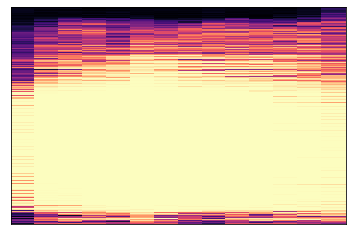

In [ ]:
import librosa
import librosa.display
zaladowane = np.load('/content/gdrive/MyDrive/Inzynierka/Data/wynik_256_14_v2_test_plot150.npy')
#zaladowane = np.load('/content/gdrive/MyDrive/Inzynierka/Data/en_spectrogram_tensor/common_voice_en_22677141.mp3.npy')
print(zaladowane.shape)
#print(zaladowane[6])
print(np.max(zaladowane))
print(np.min(zaladowane))
normalized = (zaladowane * 80) - 80
print(np.max(normalized))
print(np.min(normalized))

#librosa.display.specshow(spectest)
#librosa.display.specshow((zaladowane[4].reshape(256,14)))
librosa.display.specshow((normalized[4].reshape(256,14)))
#print(normalized[2])

[[[-23.449314]
  [-21.314655]
  [-20.130074]
  ...
  [-15.720505]
  [-15.413637]
  [-18.132267]]

 [[-20.931906]
  [-16.147062]
  [-15.618837]
  ...
  [-16.096972]
  [-16.254475]
  [-18.97048 ]]

 [[-21.80932 ]
  [-18.317947]
  [-17.260685]
  ...
  [-17.650433]
  [-16.410334]
  [-19.037704]]

 ...

 [[-36.42886 ]
  [-27.301575]
  [-32.69501 ]
  ...
  [-31.16472 ]
  [-33.298264]
  [-22.727163]]

 [[-37.16504 ]
  [-28.940487]
  [-34.157207]
  ...
  [-26.451168]
  [-32.75688 ]
  [-22.91378 ]]

 [[-34.418297]
  [-28.58567 ]
  [-34.693954]
  ...
  [-33.893692]
  [-34.827087]
  [-31.562351]]]


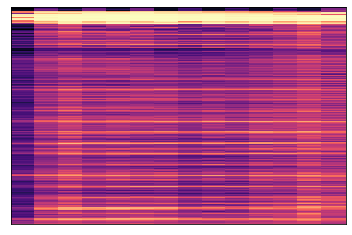

In [ ]:

librosa.display.specshow((normalized[4].reshape(256,14)))
print(normalized[1])

(12195, 256, 16, 1)
[[24.685812  18.110788  15.338776  ... 14.57552   14.815999  14.759249 ]
 [14.639329  14.446907  15.291615  ... 14.772142  14.732388  14.846724 ]
 [15.18671   14.674301  15.2182455 ... 14.776593  15.001476  14.558247 ]
 ...
 [15.446796  14.728373  15.39467   ... 14.949194  15.163134  15.249122 ]
 [15.662478  15.011696  15.327721  ... 14.851523  15.267255  15.190759 ]
 [15.429316  14.631171  14.959035  ... 14.997301  21.327711  29.415123 ]]


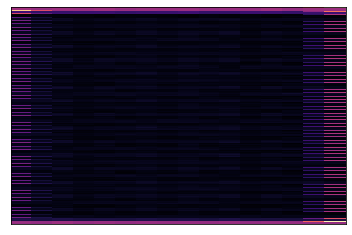

In [ ]:






print(data_tensor.shape)
spectest = zaladowane[1]
spectest = spectest.reshape(256,16)
spectest = (spectest*127.5)
print(spectest)
librosa.display.specshow(spectest)

In [ ]:
# To restore checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
